In this project, we aim to build a Recurrent Neural Network (RNN) for Sentiment Analysis using PyTorch as the deep learning framework.

To preprocess and clean the text data, we’ll use NLTK (Natural Language Toolkit) — a powerful library for handling tasks like tokenization, stop word removal, and text normalization.

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

notebook_path = '/content/drive/My Drive/Colab Notebooks'  # Change this to match your folder
os.chdir(notebook_path)  # Change the working directory to your notebook folder
print("Current Directory:", os.getcwd())

Current Directory: /content/drive/My Drive/Colab Notebooks


In [ ]:
import re
import nltk
import torch
import string
import pandas as pd
import inflect
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup


In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))
p = inflect.engine()
tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df = pd.read_csv('IMDB Dataset.csv')  # No need for full path since we set the working directory
print(df.head())  # Display first few rows

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Function to check if text contains digits
def contains_digit(text):
    return bool(re.search(r'\d', text))

# Apply the function to the 'text' column
df['contains_digits'] = df['review'].apply(contains_digit)

print(df['contains_digits'].value_counts())

contains_digits
True     28005
False    21995
Name: count, dtype: int64


In [ ]:

print(f"Null values: {df.isnull().sum()}")
print(f"Dublicate values: {df.duplicated().sum()}")


Null values: review             0
sentiment          0
contains_digits    0
dtype: int64
Dublicate values: 418


In [ ]:
#df = df.drop_duplicates()
print(f"Dublicate values: {df.duplicated().sum()}")

Dublicate values: 418


In [ ]:
import pdb
def clean_text(text):
    # Convert text to lowercase

    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove user mentions (like @username) and hashtags (#hashtag)
    text = re.sub(r"@[\w]+|#\w+", "", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize words
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))

    words = [word for word in words if word not in stop_words]
    #words = [p.number_to_words(word) if word.isdigit() else word for word in words]


    # Join words back into a cleaned sentence
    return " ".join(words)

In [ ]:
df["clean_review"] = df["review"].progress_apply(clean_text)


In [ ]:
df1= df
df1["text_length"] = df1["clean_review"].apply(lambda x: len(str(x).split()))

# Show summary statistics
print(df1["text_length"].describe())
print(f"No of review words greater than 2000: {df1[df1['text_length'] > 250].shape[0]}")

count    50000.00000
mean       119.83162
std         90.08235
min          3.00000
25%         64.00000
50%         89.00000
75%        146.00000
max       1429.00000
Name: text_length, dtype: float64
No of review words greater than 2000: 4365


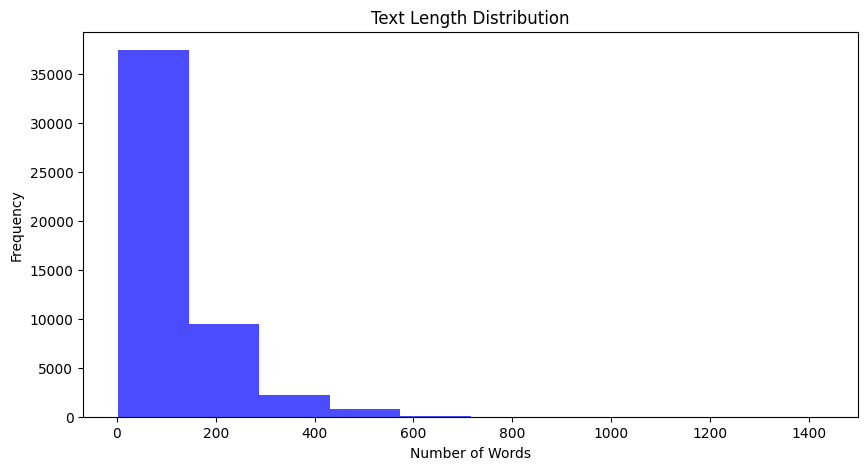

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df1["text_length"], bins=10, color="blue", alpha=0.7)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

In [ ]:
print(df['clean_review'][0])
#df = df[df["clean_review"].apply(lambda x: len(str(x).split()) <= 200)]


one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle c

In [ ]:
df["tokens"] = df["clean_review"].progress_apply(lambda x: x.split())



In [ ]:
max_seq_len = df['tokens'].apply(len).max()
print("Maximum tokens length:", max_seq_len)
print(df["tokens"][0])
print(df["clean_review"][0])

Maximum tokens length: 1429
['one', 'reviewers', 'mentioned', 'watching', '1', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'methe', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'wordit', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'manyaryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'moreso', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'awayi', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'wouldnt', 'dare', 'forget', 'pretty', 'p

In [ ]:
from collections import Counter

# Flatten all tokens into a single list
all_words = [word for tokens in df["tokens"] for word in tokens]

# Count frequency of each word
word_counts = Counter(all_words)

# Define vocabulary size
vocab_size = 20000

# Create word-to-index mapping
word_to_index = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(vocab_size))}
print(word_to_index)
# Add special tokens
word_to_index["<OOV>"] = len(word_to_index) + 1
word_to_index["<PAD>"] = 0
print(word_to_index)
# Reverse mapping for index-to-word
index_to_word = {idx: word for word, idx in word_to_index.items()}
print(index_to_word)

{'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5, 'even': 6, 'would': 7, 'time': 8, 'really': 9, 'see': 10, 'story': 11, 'much': 12, 'well': 13, 'get': 14, 'great': 15, 'bad': 16, 'also': 17, 'people': 18, 'first': 19, 'dont': 20, 'movies': 21, 'made': 22, 'make': 23, 'films': 24, 'could': 25, 'way': 26, 'characters': 27, 'think': 28, 'watch': 29, 'many': 30, 'seen': 31, 'two': 32, 'character': 33, 'never': 34, 'love': 35, 'acting': 36, 'little': 37, 'plot': 38, 'best': 39, 'know': 40, 'show': 41, 'life': 42, 'ever': 43, 'better': 44, 'say': 45, 'still': 46, 'scene': 47, 'end': 48, 'man': 49, 'scenes': 50, 'something': 51, 'go': 52, 'back': 53, 'real': 54, 'im': 55, 'watching': 56, 'thing': 57, 'doesnt': 58, 'didnt': 59, 'actors': 60, 'years': 61, 'actually': 62, 'though': 63, 'funny': 64, 'makes': 65, 'another': 66, 'find': 67, 'nothing': 68, 'look': 69, 'going': 70, 'work': 71, 'lot': 72, 'new': 73, 'every': 74, 'old': 75, 'us': 76, 'part': 77, 'cant': 78, 'director': 79, 'want

In [ ]:
def tokens_to_sequence(tokens):
    return [word_to_index.get(word, word_to_index["<OOV>"]) for word in tokens]

# Apply the transformation
df["sequences"] = df["tokens"].apply(tokens_to_sequence)
print(df["sequences"][0])
max_seq_len = df['sequences'].apply(len).max()
print("Maximum sequence length:", max_seq_len)

[3, 1809, 940, 56, 425, 3217, 286, 349, 3028, 107, 481, 470, 7413, 19, 57, 3098, 3217, 5386, 14835, 50, 472, 180, 107, 548, 52, 1605, 41, 8026, 5581, 11458, 41, 2359, 5835, 5493, 1339, 276, 472, 3260, 246, 233, 20001, 353, 3217, 11124, 240, 15440, 6674, 2419, 938, 20001, 2483, 1246, 20001, 421, 4559, 2376, 1079, 6877, 2831, 12562, 298, 20001, 16899, 213, 4902, 3570, 421, 236, 20001, 8154, 20001, 14836, 4992, 7606, 2319, 16900, 20001, 224, 8952, 7194, 12977, 8403, 20001, 34, 126, 20001, 7, 45, 166, 1172, 41, 550, 91, 159, 154, 436, 2845, 703, 85, 1144, 4167, 2353, 974, 703, 1282, 703, 20001, 58, 852, 88, 19, 286, 43, 103, 3098, 1451, 2067, 288, 45, 1422, 174, 1336, 1121, 3217, 83, 9932, 213, 1949, 1961, 472, 472, 7675, 6878, 4784, 13678, 2799, 20001, 6770, 13678, 380, 499, 14, 140, 13, 9590, 632, 693, 6770, 542, 1079, 19849, 550, 438, 808, 1860, 1079, 442, 56, 3217, 98, 302, 3603, 3116, 20001, 14, 1082, 3863, 392]
Maximum sequence length: 1429


In [ ]:
max_length = 500

# Convert sequences to PyTorch tensor
sequences_tensor = [torch.tensor(seq[:max_length], dtype=torch.long) for seq in df["sequences"]]

# Apply padding
reversed_sequences = [seq.flip(0) for seq in sequences_tensor]

padded_sequences = pad_sequence(reversed_sequences, batch_first=True, padding_value=word_to_index["<PAD>"])
padded_sequences = padded_sequences.flip(1)

labels_tensor = torch.tensor([1 if label == 'positive' else 0 for label in df['sentiment']], dtype=torch.float32)
torch.set_printoptions(threshold=torch.inf)



In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels =  labels# Convert labels to tensor

    def __len__(self):
        return len(self.sequences)


    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Convert dataset into PyTorch format
dataset = SentimentDataset(padded_sequences, labels_tensor)

# Split into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset))
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

40000


In [ ]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

# Load pre-trained GloVe vectors (100-dimensional)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size + 2, embedding_dim))

# Load the GloVe vectors using gensim
glove_vectors = KeyedVectors.load_word2vec_format("glove.6B.100d.txt", binary=False, no_header=True)

# Create the embedding matrix by mapping words to their embeddings
for word, index in word_to_index.items():
    if word in glove_vectors:
        embedding_matrix[index] = glove_vectors[word]
embedding_matrix[word_to_index['<PAD>']] = np.zeros(embedding_dim)

# <OOV>: assign a random vector (or average of all embeddings if you want)
embedding_matrix[word_to_index['<OOV>']] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [ ]:
print(embedding_matrix.shape)

(20002, 100)


In [ ]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout):
        super(SentimentRNN, self).__init__()

        embedding_dim = 100

        # Embedding layer using pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)

        # RNN layer (can be LSTM or GRU too)
        self.rnn = nn.RNN(input_size=embedding_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = self.embedding(x)             # [batch_size, seq_len, embedding_dim]
        out, _ = self.rnn(x)              # [batch_size, seq_len, hidden_dim]
        out = out[:, -1, :]               # Take the last time step's output
        out = self.fc(out)                # [batch_size, 1]
        return self.sigmoid(out)          # [batch_size, 1]

In [ ]:
model = SentimentRNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=3,
    dropout=0.5
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


SentimentRNN(
  (embedding): Embedding(20002, 100)
  (rnn): RNN(100, 128, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
val_loss_list = []
train_loss_list = []

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total = 0.0
        correct = 0.0
        print(f"\n🔁 Epoch {epoch+1}/{epochs}")
        train_loop = tqdm(train_loader, total=len(train_loader), desc="Training", leave=False)

        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())
            predicted = (outputs.data > 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"✅ Epoch {epoch+1} Training Loss: {running_loss/len(train_loader):.4f}")
        train_loss_list.append(running_loss/len(train_loader))
        train_accuracy = correct / total
        print(f"🟢 Training Accuracy: {train_accuracy:.4f}")

        evaluate(model, test_loader)

In [ ]:
# Evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    running_loss = 0.0

    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move the inputs and labels to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs.squeeze(), labels.float())  # Use .squeeze() for single output
            running_loss += loss.item()

            # Convert the output probabilities to binary predictions (0 or 1)
            preds = (outputs.squeeze() > 0.5).cpu().numpy()  # For binary classification, threshold at 0.5

            # Store the predictions and true labels
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate the average loss
    avg_loss = running_loss / len(dataloader)
    val_loss_list.append(avg_loss)

    # Print the evaluation results
    print(f'Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return avg_loss, accuracy, precision, recall, f1



In [ ]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)


🔁 Epoch 1/5


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

✅ Epoch 1 Training Loss: 0.5860
🟢 Training Accuracy: 0.8104
Loss: 0.6359
Accuracy: 0.6750
Precision: 0.8259
Recall: 0.4320
F1 Score: 0.5672

🔁 Epoch 2/5


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

✅ Epoch 2 Training Loss: 0.5800
🟢 Training Accuracy: 0.8341
Loss: 0.5942
Accuracy: 0.8123
Precision: 0.8350
Recall: 0.7719
F1 Score: 0.8022

🔁 Epoch 3/5


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

✅ Epoch 3 Training Loss: 0.5707
🟢 Training Accuracy: 0.8500
Loss: 0.5849
Accuracy: 0.8264
Precision: 0.8692
Recall: 0.7627
F1 Score: 0.8125

🔁 Epoch 4/5


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

✅ Epoch 4 Training Loss: 0.5757
🟢 Training Accuracy: 0.8303
Loss: 0.5909
Accuracy: 0.7958
Precision: 0.9086
Recall: 0.6514
F1 Score: 0.7588

🔁 Epoch 5/5


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

✅ Epoch 5 Training Loss: 0.5670
🟢 Training Accuracy: 0.8541
Loss: 0.5857
Accuracy: 0.8351
Precision: 0.8434
Recall: 0.8173
F1 Score: 0.8302


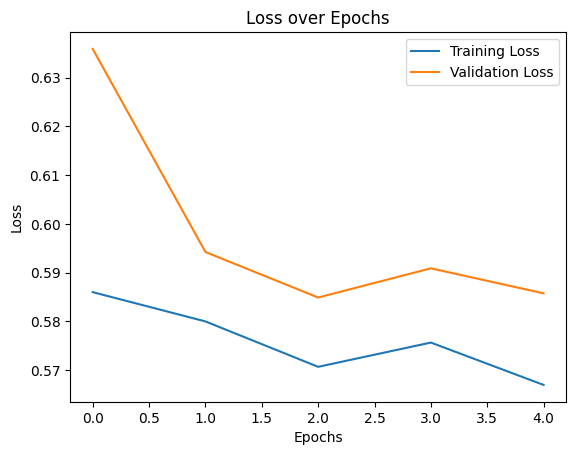

In [ ]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()